# Project 3: Web APIs & Classification
### Part 3: Preprocessing and Modeling
_Authors: Evonne_

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

sns.set_style('whitegrid')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Read in Data

In [2]:
df = pd.read_csv('./datasets/df.csv')
df.head()

,id,title,comment,date_created,score,subreddit,title_len
0,hdge6q,Hey All! I made a documentary about Joe Biden....,None,2020-06-21 22:55:13,29,1,108
1,hff6bt,It’s Time for a Blue Wave to Restore America.,None,2020-06-25 03:24:22,629,1,45
2,hf7pni,"In Scathing Letter, More Than 80-Percent of Fa...",None,2020-06-24 19:33:43,1336,1,114
3,hfgpv1,Mark Cuban endorses Biden on Hannity: He 'actu...,None,2020-06-25 05:54:06,70,1,74
4,hf6wes,Judiciary Democrat calls for House to pursue i...,None,2020-06-24 18:52:00,201,1,64


In [3]:
df.shape

(1784, 7)

## 3. Baseline accuracy

In [4]:
x = df['subreddit'].value_counts(normalize = True)
x[1]

0.5487668161434978

The accuracy of our baseline model is 56% which seem to be well balanced. 

## 4. Pre-Processing 

As this problem deals with text data, html text or punctuation will be removed, lemmatizer use to help to shorten words so we can combine similar forms of the same word, removing the stop word. 

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Vonnytham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
lemm = WordNetLemmatizer()

def text_processer(raw_text):
    
    # Remove HTML.
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # Lemmatize words.
    lemmed_words = [lemm.lemmatize(i) for i in words]
    
    # Convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # Remove stop words.
    meaningful_words = [w for w in lemmed_words if not w in stops]
    
    return(" ".join(meaningful_words))

In [7]:
df_clean = df
df_clean['title'] = df_clean['title'].map(text_processer)
df_clean

,id,title,comment,date_created,score,subreddit,title_len
0,hdge6q,hey made documentary joe biden hope fellow dem...,None,2020-06-21 22:55:13,29,1,108
1,hff6bt,time blue wave restore america,None,2020-06-25 03:24:22,629,1,45
2,hf7pni,scathing letter percent faculty bill barr law ...,None,2020-06-24 19:33:43,1336,1,114
3,hfgpv1,mark cuban endorses biden hannity actually wan...,None,2020-06-25 05:54:06,70,1,74
4,hf6wes,judiciary democrat call house pursue impeachme...,None,2020-06-24 18:52:00,201,1,64
...,...,...,...,...,...,...,...
1779,gzc851,new york time go go biden,None,2020-06-09 00:39:36,2,0,41
1780,gynk96,forbes minneapolis vote disband police department,None,2020-06-07 23:43:08,84,0,54
1781,gyroif,viral yet pt,None,2020-06-08 04:12:14,39,0,28
1782,gz60bk,pelosi delivers press conference racist garb,None,2020-06-08 19:26:46,4,0,47


In [17]:
!pip install wordcloud

In [18]:
from wordcloud import WordCloud
from PIL import Image

In [19]:
def show_wordcloud(data, title):
    wordcloud = WordCloud(
       background_color='white',
       max_words=200,
       colormap='RdBu',
       scale=3).generate(str(data))
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

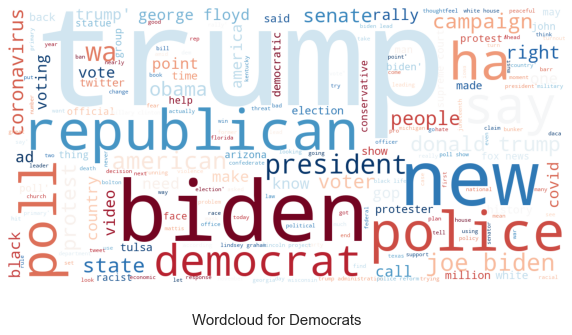

In [20]:
show_wordcloud(df_clean[df_clean["subreddit"]==1].title.values,'Wordcloud for Democrats')

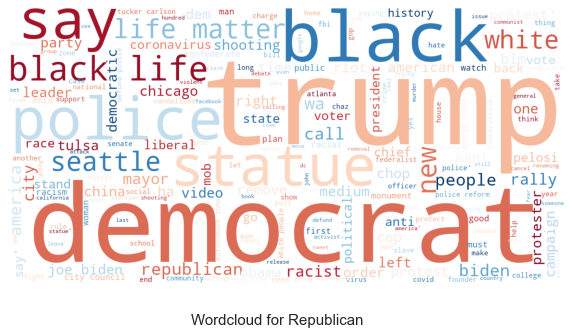

In [21]:
show_wordcloud(df_clean[df_clean["subreddit"]==0].title.values,'Wordcloud for Republican')

## 5.1. Model prep: Create `X` and `y` variables

Predicting the subreddit that a comment has come from, is a classification problem. Hence, classification models will be used. 

Our target column will be `subreddit`: 
- 1 represents the Democrats
- 0 represents the Republican

In [22]:
X = df_clean[['title']]
y = df_clean['subreddit']

## 5.2. Model Prep: Train/Test Split

In [23]:
# Split our data into training and testing sets.
# stratify y as to make sure they are the same as the target given that they are not balanced.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [24]:
y_train

767     1
96      1
1650    0
1163    0
1088    0
       ..
1423    0
114     1
910     1
1721    0
1102    0
Name: subreddit, Length: 1338, dtype: int64

## 6. Create a bag-of-words model
In order to analyze and make prediction on Reddit comments, it is required to vectorize the text of the comments into numerical values. Two of many vectorizers will be explored.
1. CountVectorizer: where it counts the number of times a token shows up in the document and uses this value as its weight.
2. TF-IDF (term frequency-inverse document frequency): weight assigned to each token depends on its frequency in a document and how recurrent that term is in the entire corpora

Both can:
- Split the documents into tokens by following some sort of pattern.
- Assign a weight to each token proportional to the frequency with which it shows up in the document and/or corpora.
- Create a document-term matrix with each row representing a document and each column addressing a token.


### 6.1. CountVectorizer

In [25]:
# Instantiate our CountVectorizer.
# eliminate commonly used words from corpus using stop_words.
cvec = CountVectorizer(stop_words='english',
                      max_features = 5000)

In [26]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(),
                           columns = cvec.get_feature_names())

In [27]:
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title']).todense(),
                          columns = cvec.get_feature_names())

In [28]:
X_train_cvec.shape

(1338, 3598)

In [29]:
# Create a df for top occured words
tw = X_train_cvec.sum().sort_values(ascending=False).head(20)
tw_df = pd.DataFrame(tw, columns = ['count'])
tw_df['word'] = tw_df.index
tw_df.reset_index(drop=True, inplace=True)
tw_df

,count,word
0,356,trump
1,131,biden
2,109,police
3,88,democrat
4,82,say
5,81,black
6,64,new
7,57,protest
8,57,republican
9,55,poll


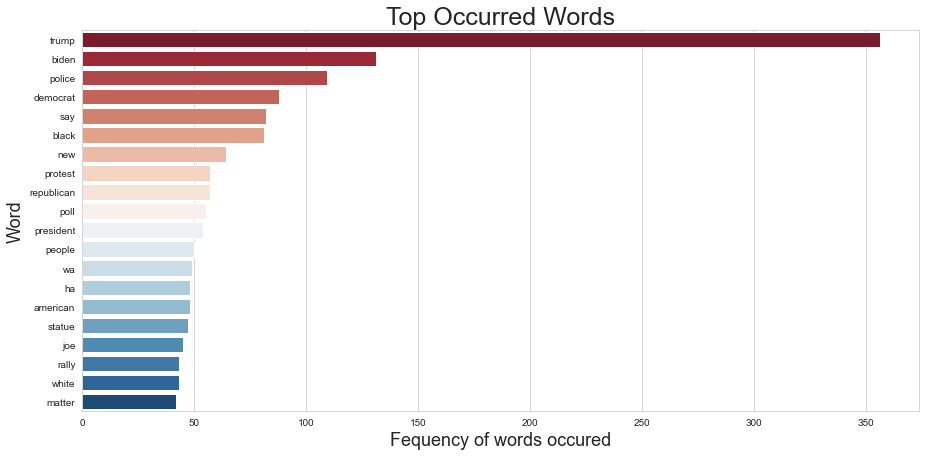

In [30]:
# Visualize top words using Barplot
plt.figure(figsize=(15,7))
plt.title("Top Occurred Words", fontsize=25)

sns.barplot(data = tw_df, x = 'count', y ='word', orient = 'h', palette='RdBu')

plt.xlabel('Fequency of words occured', fontsize = 18)
plt.ylabel('Word', fontsize = 18);

For this project, where it is a classification problem, classification model will be you. Here, 3 models will be explored:

1. Logistic Regression - predicting continous target y value between (0,1)
2. Naive Bayes - Multinomial Classifier - Since the columns of df are all integer counts, so MultinomialNB is the best choice here
3. KNearest-Neighbor

#### 6.1.1. Fit a Default Logistic Regression using CountVectorizer

In [31]:
lr = LogisticRegression()

# cross_val_score for Logistic Regression.
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(lr, X_train_cvec, y_train, cv=5).mean()))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Model with Cross-Validation: 0.695870272696667


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
lr_model = lr.fit(X_train_cvec, y_train)

print("lr score on training set with default parameters: {}". format(lr_model.score(X_train_cvec, y_train)))
print("lr score on testing set with default parameters: {}". format(lr_model.score(X_test_cvec, y_test)))

lr score on training set with default parameters: 0.9693572496263079
lr score on testing set with default parameters: 0.7466367713004485


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 6.1.2. Fit a Default Naive Bayes model using CountVectorizer

In [33]:
nb = MultinomialNB()

# cross_val_score for Naive Bayes.
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(nb, X_train_cvec, y_train, cv=5).mean()))

Accuracy of Model with Cross-Validation: 0.7085680619459096


In [34]:
nb_model = nb.fit(X_train_cvec, y_train)
predictions = nb_model.predict(X_test_cvec)

print("NB score on training set with default parameters: {}". format(nb_model.score(X_train_cvec, y_train)))
print("NB score on testing set with default parameters: {}". format(nb_model.score(X_test_cvec, y_test)))

NB score on training set with default parameters: 0.9155455904334828
NB score on testing set with default parameters: 0.7354260089686099


#### 6.1.3.  Fit a Default KNearest Neighbor using CountVectorizer

In [35]:
knn = KNeighborsClassifier()

# cross_val_score for KNN.
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(knn, X_train_cvec, y_train, cv=5).mean()))

Accuracy of Model with Cross-Validation: 0.5642688811581192


In [36]:
knn_model = knn.fit(X_train_cvec, y_train)
#knn_prediction = knn_model.predict(X_test_cvec)

In [37]:
print("KNN score on training set with default parameters: {}". format(knn_model.score(X_train_cvec, y_train)))
print("KNN score on testing set with default parameters: {}". format(knn_model.score(X_test_cvec, y_test)))

KNN score on training set with default parameters: 0.8183856502242153
KNN score on testing set with default parameters: 0.600896860986547


By comparing these three classification models, the cross validation score are pretty good, though not extremely high for especially for the the KNN model. 
Furthermore, amongst all the model tested, Naive bayes seem to perform the best. However, all model shows a drop in accuracy in test score, which indicates serious overfitting.

### 6.2. TF-IDF

In [38]:
tvec = TfidfVectorizer(stop_words='english')

# Fit and transform our TF-IDF on the training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['title']).todense(),
                           columns = tvec.get_feature_names())
# Transform our TF-IDF on the test data.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['title']).todense(),
                          columns = tvec.get_feature_names())

#### 6.2.1. Fit a Default Logistic Regression using TFID

In [39]:
lr = LogisticRegression()

# cross_val_score for Logistic Regression.
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(lr, X_train_tvec, y_train, cv=5).mean()))

Accuracy of Model with Cross-Validation: 0.7033329592638312


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [40]:
lr_model = lr.fit(X_train_tvec, y_train)

print("lr score on training set with default parameters: {}". format(lr_model.score(X_train_tvec, y_train)))
print("lr score on testing set with default parameters: {}". format(lr_model.score(X_test_tvec, y_test)))

lr score on training set with default parameters: 0.9177877428998505
lr score on testing set with default parameters: 0.7286995515695067


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 6.2.2. Fit a Default Naive Bayes model using TFID

In [41]:
nb = MultinomialNB()

# cross_val_score for Naive Bayes.
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(nb, X_train_tvec, y_train, cv=5).mean()))

Accuracy of Model with Cross-Validation: 0.7010829312086185


In [42]:
nb_model = nb.fit(X_train_tvec, y_train)

print("NB score on training set with default parameters: {}". format(nb_model.score(X_train_tvec, y_train)))
print("NB score on testing set with default parameters: {}". format(nb_model.score(X_test_tvec, y_test)))

NB score on training set with default parameters: 0.9185351270553064
NB score on testing set with default parameters: 0.7242152466367713


#### 6.3.3. Fit a KNearest Neighbor baseline model

In [43]:
knn = KNeighborsClassifier()

# Get a cross_val_score for KNN.
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(knn, X_train_tvec, y_train, cv=5).mean()))

Accuracy of Model with Cross-Validation: 0.6225788351475705


In [44]:
knn_model = knn.fit(X_train_tvec, y_train)

print("KNN score on training set with default parameters: {}". format(knn_model.score(X_train_tvec, y_train)))
print("KNN score on testing set with default parameters: {}". format(knn_model.score(X_test_tvec, y_test)))

KNN score on training set with default parameters: 0.8236173393124065
KNN score on testing set with default parameters: 0.647982062780269


Similar to models using CountVectorizer, the models are very overfitted to the data. This can be due to the lack of data, since reddit only allow scrapping of 1000 post per subreddit. We can attempt to increase bias in our training set in order to lower variance in the test set by searching for the best hyperparameters. 

## 7. Searching for the Best Hyperparameters
### 7.1. GridSearchCV: CountVectorizer  
#### 7.1.1. With Logistic Regression

In [45]:
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('lr', LogisticRegression())])

# looking at the hyperparameters within the pipeline
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cvec', 'lr', 'cvec__analyzer', 'cvec__binary', 'cvec__decode_error', 'cvec__dtype', 'cvec__encoding', 'cvec__input', 'cvec__lowercase', 'cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'cvec__preprocessor', 'cvec__stop_words', 'cvec__strip_accents', 'cvec__token_pattern', 'cvec__tokenizer', 'cvec__vocabulary', 'lr__C', 'lr__class_weight', 'lr__dual', 'lr__fit_intercept', 'lr__intercept_scaling', 'lr__l1_ratio', 'lr__max_iter', 'lr__multi_class', 'lr__n_jobs', 'lr__penalty', 'lr__random_state', 'lr__solver', 'lr__tol', 'lr__verbose', 'lr__warm_start'])

In [46]:
pipe_params = {'cvec__max_features': [1000, 1500, 2000, 2500, 3000, 3500],
               'cvec__min_df': [2, 3],
               'cvec__max_df': [.9, .95],
               'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (1,2)],
               'lr__penalty':['l2','l1'],
               'lr__C': [1, 0.1, .01]}

In [47]:
gscv_lr = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=3, n_jobs=-1)
gscv_lr.fit(X_train['title'], y_train)
print("Best combination of hyperparameters:", gscv_lr.best_params_)
print('Best mean cross-validated score achieved:', gscv_lr.best_score_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   40.5s


Best combination of hyperparameters: {'cvec__max_df': 0.9, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'lr__C': 0.1, 'lr__penalty': 'l2'}
Best mean cross-validated score achieved: 0.6973094170403588


[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:   47.2s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [48]:
# Scoring it on both training and test set
print(f"Score on training set with best params: {gscv_lr.score(X_train['title'], y_train)}")
print(f"Score on testing set with best params: {gscv_lr.score(X_test['title'], y_test)}")

Score on training set with best params: 0.8303437967115097
Score on testing set with best params: 0.7085201793721974


#### 7.1.2. With Naive Bayes

In [49]:
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('nb', MultinomialNB())])

# looking at the hyperparameters within the pipeline
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cvec', 'nb', 'cvec__analyzer', 'cvec__binary', 'cvec__decode_error', 'cvec__dtype', 'cvec__encoding', 'cvec__input', 'cvec__lowercase', 'cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'cvec__preprocessor', 'cvec__stop_words', 'cvec__strip_accents', 'cvec__token_pattern', 'cvec__tokenizer', 'cvec__vocabulary', 'nb__alpha', 'nb__class_prior', 'nb__fit_prior'])

In [50]:
pipe_params = {'cvec__max_features': [1000, 1500, 2000, 2500, 3000, 3500],
               'cvec__min_df': [2, 3],
               'cvec__max_df': [.9, .95],
               'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (1,2)],
               'nb__alpha': np.linspace(0.5, 1.5, 6),
               'nb__fit_prior': [True, False]
              }

In [51]:
gscv_nb = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=3, n_jobs=-1)
gscv_nb.fit(X_train['title'], y_train)
print("Best combination of hyperparameters:", gscv_nb.best_params_)
print('Best mean cross-validated score achieved:', gscv_nb.best_score_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:  1.0min


Best combination of hyperparameters: {'cvec__max_df': 0.9, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'nb__alpha': 0.7, 'nb__fit_prior': True}
Best mean cross-validated score achieved: 0.7085201793721974


[Parallel(n_jobs=-1)]: Done 3456 out of 3456 | elapsed:  1.2min finished


In [52]:
# Scoring it on both training and test set
print(f"Score on training set with best params: {gscv_nb.score(X_train['title'], y_train)}")
print(f"Score on testing set with best params: {gscv_nb.score(X_test['title'], y_test)}")

Score on training set with best params: 0.8602391629297459
Score on testing set with best params: 0.7309417040358744


#### 7.1.3. With KNearest-Neighbor

In [53]:
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('knn', KNeighborsClassifier())])

# looking at the hyperparameters within the pipeline
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cvec', 'knn', 'cvec__analyzer', 'cvec__binary', 'cvec__decode_error', 'cvec__dtype', 'cvec__encoding', 'cvec__input', 'cvec__lowercase', 'cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'cvec__preprocessor', 'cvec__stop_words', 'cvec__strip_accents', 'cvec__token_pattern', 'cvec__tokenizer', 'cvec__vocabulary', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])

In [54]:
pipe_params = {'cvec__max_features': [1000, 1500, 2000, 2500, 3000, 3500],
               'cvec__min_df': [2, 3],
               'cvec__max_df': [.9, .95],
               'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (1,2)],
               'knn__n_neighbors': [1,3,5,7,9],
               'knn__weights': ['uniform','distance'], 
               'knn__metric': ['euclidean','manhattan']
              }

In [55]:
gscv_knn = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=3, n_jobs=-1)
gscv_knn.fit(X_train['title'], y_train)
print("Best combination of hyperparameters:", gscv_knn.best_params_)
print('Best mean cross-validated score achieved:', gscv_knn.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 1908 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3444 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4404 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 5492 tasks      | elapsed:  4.4min


Best combination of hyperparameters: {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Best mean cross-validated score achieved: 0.6121076233183856


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  4.6min finished


In [56]:
# Scoring it on both training and test set
print(f"Score on training set with best params: {gscv_knn.score(X_train['title'], y_train)}")
print(f"Score on testing set with best params: {gscv_knn.score(X_test['title'], y_test)}") 

Score on training set with best params: 0.6853512705530643
Score on testing set with best params: 0.6210762331838565


Logistic Regression and Naive Bayes did comparably well. KNN is seriously overfitting here.

### 7.2. GridSearchCV: TF-IDF 
#### 7.2.1. With Logistic Regression

In [57]:
pipe = Pipeline([('tvec', TfidfVectorizer()),
                 ('lr', LogisticRegression())])

pipe_params = {'tvec__max_features': [1000, 1500, 2000, 2500, 3000, 3500],
               'tvec__min_df': [2, 3],
               'tvec__max_df': [.9, .95],
               'tvec__stop_words': [None, 'english'],
               'tvec__ngram_range': [(1,1), (1,2)],
               'lr__C': [1, 0.1, .01]}

gstv_lr = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=3, n_jobs=-1)
gstv_lr.fit(X_train['title'], y_train)
print("Best combination of hyperparameters:", gstv_lr.best_params_)
print('Best mean cross-validated score achieved:', gstv_lr.best_score_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   13.4s


Best combination of hyperparameters: {'lr__C': 1, 'tvec__max_df': 0.9, 'tvec__max_features': 1500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Best mean cross-validated score achieved: 0.6943198804185351


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   17.7s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [58]:
# Scoring it on both training and test set
print(f"Score on training set with best params: {gstv_lr.score(X_train['title'], y_train)}")
print(f"Score on testing set with best params: {gstv_lr.score(X_test['title'], y_test)}") 

Score on training set with best params: 0.8774289985052317
Score on testing set with best params: 0.726457399103139


#### 7.2.2. With Naive Bayes

In [59]:
pipe = Pipeline([('tvec', TfidfVectorizer()),
                 ('nb', MultinomialNB())])

pipe_params = {'tvec__max_features': [1000, 1500, 2000, 2500, 3000, 3500],
               'tvec__min_df': [2, 3],
               'tvec__max_df': [.9, .95],
               'tvec__stop_words': [None, 'english'],
               'tvec__ngram_range': [(1,1), (1,2)],
               'nb__alpha': np.linspace(0.5, 1.5, 6),
               'nb__fit_prior': [True, False]}

gstv_nb = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=3, n_jobs=-1)
gstv_nb.fit(X_train['title'], y_train)
print("Best combination of hyperparameters:", gstv_nb.best_params_)
print('Best mean cross-validated score achieved:', gstv_nb.best_score_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:  1.2min


Best combination of hyperparameters: {'nb__alpha': 1.5, 'nb__fit_prior': True, 'tvec__max_df': 0.9, 'tvec__max_features': 1000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
Best mean cross-validated score achieved: 0.6995515695067265


[Parallel(n_jobs=-1)]: Done 3456 out of 3456 | elapsed:  1.3min finished


In [60]:
# Scoring it on both training and test set
print(f"Score on training set with best params: {gstv_nb.score(X_train['title'], y_train)}")
print(f"Score on testing set with best params: {gstv_nb.score(X_test['title'], y_test)}") 

Score on training set with best params: 0.827354260089686
Score on testing set with best params: 0.742152466367713


#### 7.2.3. With KNearest-Neighbor

In [61]:
pipe = Pipeline([('tvec', TfidfVectorizer()),
                 ('knn', KNeighborsClassifier())])

pipe_params = {'tvec__max_features': [1000, 1500, 2000, 2500, 3000, 3500],
               'tvec__min_df': [2, 3],
               'tvec__max_df': [.9, .95],
               'tvec__stop_words': [None, 'english'],
               'tvec__ngram_range': [(1,1), (1,2)],
               'knn__n_neighbors': [1,3,5,7,9],
               'knn__weights': ['uniform','distance'], 
               'knn__metric': ['euclidean','manhattan']}

gstv_knn = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=3, n_jobs=-1)
gstv_knn.fit(X_train['title'], y_train)
print("Best combination of hyperparameters:", gstv_knn.best_params_)
print('Best mean cross-validated score achieved:', gstv_knn.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 2688 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3648 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4736 tasks      | elapsed:  3.2min


Best combination of hyperparameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'tvec__max_df': 0.9, 'tvec__max_features': 1500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
Best mean cross-validated score achieved: 0.5724962630792227


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  4.2min finished


In [62]:
# Scoring it on both training and test set
print(f"Score on training set with best params: {gstv_knn.score(X_train['title'], y_train)}")
print(f"Score on testing set with best params: {gstv_knn.score(X_test['title'], y_test)}") 

Score on training set with best params: 0.6823617339312407
Score on testing set with best params: 0.5829596412556054


In [63]:
scoring = [{'Model Combination': 'Baseline Model', 'Best Score': x[1]},
           {'Model Combination': 'CountVec_LR', 
            'Best Score': gscv_lr.best_score_, 
            'Train Accuracy': gscv_lr.score(X_train['title'], y_train), 
            'Test Accuracy': gscv_lr.score(X_test['title'], y_test)}, 
           {'Model Combination': 'CountVec_NB', 
            'Best Score': gscv_nb.best_score_, 
            'Train Accuracy': gscv_nb.score(X_train['title'], y_train), 
            'Test Accuracy': gscv_nb.score(X_test['title'], y_test)}, 
           {'Model Combination': 'CountVec_KNN', 
            'Best Score': gscv_knn.best_score_, 
            'Train Accuracy': gscv_knn.score(X_train['title'], y_train), 
            'Test Accuracy': gscv_knn.score(X_test['title'], y_test)},
           {'Model Combination': 'TFID_LR', 
            'Best Score': gstv_lr.best_score_, 
            'Train Accuracy': gstv_lr.score(X_train['title'], y_train), 
            'Test Accuracy': gstv_lr.score(X_test['title'], y_test)}, 
           {'Model Combination': 'TFID_NB', 
            'Best Score': gstv_nb.best_score_, 
            'Train Accuracy': gstv_nb.score(X_train['title'], y_train), 
            'Test Accuracy': gstv_nb.score(X_test['title'], y_test)}, 
           {'Model Combination': 'TFID_KNN', 
            'Best Score': gstv_knn.best_score_, 
            'Train Accuracy': gstv_knn.score(X_train['title'], y_train), 
            'Test Accuracy': gstv_knn.score(X_test['title'], y_test)}
           
          ]
scoring = pd.DataFrame(scoring)
scoring

,Model Combination,Best Score,Train Accuracy,Test Accuracy
0,Baseline Model,0.548767,NaN,NaN
1,CountVec_LR,0.697309,0.830344,0.708520
2,CountVec_NB,0.708520,0.860239,0.730942
3,CountVec_KNN,0.612108,0.685351,0.621076
4,TFID_LR,0.694320,0.877429,0.726457
5,TFID_NB,0.699552,0.827354,0.742152
6,TFID_KNN,0.572496,0.682362,0.582960


As shown above, with respect to all the models that were tested, the Naive Bayes, Multinomial with CountVectorizer yields the best score of 71.8% with 83.8% on the training set and 72.8% on testing set. Furthermore, comparing with the baseline accuracy score of 58%, it has showed considerable improvement. 


The final selected model uses the following parameters: 
- uses Count Vectorization with Naive Bayes
    - with word appearing 90% in all documents
    - with word appearing minimally 2 documents
    - max features: 1000
    - includes n-grams of length 1-2
    - include english stop words
- uses multinomial regularization with strength  α  = 1.5

Hence, we will explore further.

## 8. Model Evaluation

In [64]:
# Assign the best estimator to a variable
best_mod = gscv_nb.best_estimator_
# Generate predictions on test set.
best_mod_y_pred = best_mod.predict(X_test['title'])

### 8.1. Confusion Matrix 

In [65]:
print(classification_report(y_test, 
                            best_mod_y_pred, 
                            target_names = ['Democrats','Republican']))

              precision    recall  f1-score   support

   Democrats       0.73      0.64      0.68       201
  Republican       0.73      0.81      0.77       245

    accuracy                           0.73       446
   macro avg       0.73      0.72      0.72       446
weighted avg       0.73      0.73      0.73       446



Looking at the performance of our classifier on the test dataset, the precision of the prediction for both subreddit are the same. However, the recall, or sensitivity, varies significantly between the two politician groups. 

this suggest that the model has a harder time detecting comments that comes from r/democrats (only 59%) as compared to comments that comes from r/Republican (80%). This suggest that words from Republican subreddits are more distinct and unique to that subreddit. 

In [66]:
tn, fp, fn, tp = confusion_matrix(y_test, best_mod_y_pred).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print('')

accuracy = (tp+tn)/(tp+fp+fn+tn)
recall = tp/(tp+fn) 
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy: ', round(accuracy, 2))
print('Recall: ', round(recall, 2))
print('Specificity: ', round(specificity, 2))
print('Precision: ', round(precision, 2))

True Negatives: 128
False Positives: 73
False Negatives: 47
True Positives: 198

Accuracy:  0.73
Recall:  0.81
Specificity:  0.64
Precision:  0.73


### 8.2. ROC AUC
Visualize tradeoff between sensitivity and specificity and understand how well-separated the populations are.

In [67]:
# Create dataframe contains list of true values of our test set and predicted probabilities based on best model.
pred_proba = [i[1] for i in best_mod.predict_proba(X_test['title'])]
pred_df = pd.DataFrame({'true_values': y_test, 
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
1633,0,0.125864
1748,0,0.005772
828,1,0.999928
1109,0,0.260361
1713,0,0.287948
...,...,...
1013,0,0.721745
714,1,0.831996
920,1,0.997647
549,1,0.996984


In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8069956340745252

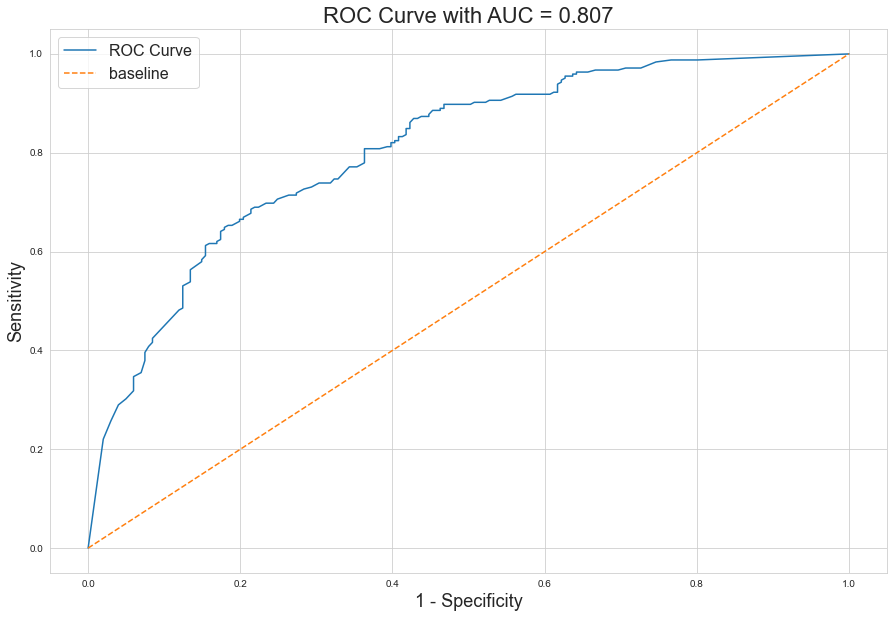

In [69]:
plt.figure(figsize = (15,10))

thresholds = np.linspace(0, 1, 200)

# Sensitivity: True positive rate
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# 1 - specificity: False positive rate
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]


plt.plot(fpr_values,
         tpr_values,
         label='ROC Curve')

# Basline
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', 
          fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

plt.legend(fontsize=16);

The closer the ROC AUC is to 1, the better the model. Indication of the positive and negative population are perfectly separated. 
And given that the ROC AUC is of 0.77, there is 77% chance that model will be able to distinguish between the 1s and 0s

### 8.3. Coefficients
As 1 is assigned Democrats and 0 is assigned to Republican, the strongest positive coefficients are words most predictive of democrats comments and vice versa

In [70]:
coefs = pd.DataFrame(gscv_lr.best_estimator_.steps[1][1].coef_).T
coefs.columns = ['coef']
coefs['ngram'] = gscv_lr.best_estimator_.steps[0][1].get_feature_names()
coefs = coefs[['ngram','coef']]
coefs = coefs.sort_values('coef')

In [71]:
feature_df_key = pd.concat([coefs.head(10),coefs.tail(10)], ignore_index=True)

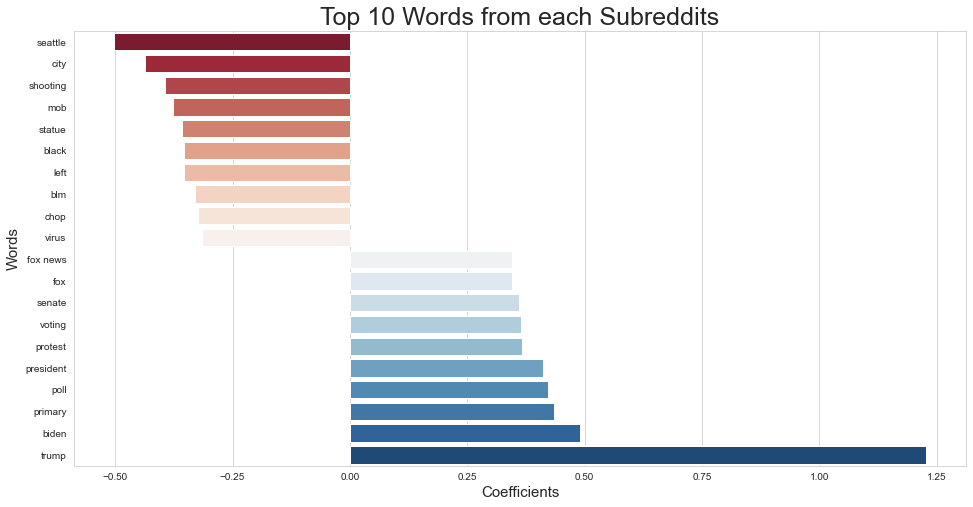

In [72]:
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(feature_df_key['coef'],feature_df_key['ngram'], palette="RdBu")
plt.title("Top 10 Words from each Subreddits", fontsize=25) 
plt.ylabel("Words", fontsize=15)
plt.xlabel("Coefficients", fontsize=15);

### 8.4. Explore posts that are incorrectly predicted

In [73]:
# Generate predictions on test set.
pred_df = pd.DataFrame(gscv_nb.predict_proba(X_test['title']), index=X_test.index)
pred_df['title'] = df['title']
pred_df['true'] = df['subreddit']
pred_df['prediction'] = best_mod_y_pred
pred_df.shape

(446, 5)

In [74]:
wrong_preds = pred_df[pred_df['true']!=pred_df['prediction']]
wrong_preds

,0,1,title,true,prediction
1556,0.451420,0.548580,go,0,1
970,0.591786,0.408214,law order,1,0
636,0.978435,0.021565,sponsor tucker carlson know buy,1,0
830,0.594284,0.405716,civil discourse,1,0
74,0.698975,0.301025,illustrated history government agency twisting...,1,0
...,...,...,...,...,...
469,0.827630,0.172370,doug jones delete account jeff came republican...,1,0
820,0.644071,0.355929,gov cuomo new fact mask important ny making hi...,1,0
713,0.892427,0.107573,thomas rid wa clear looking russian disinforma...,1,0
882,0.658080,0.341920,gov cuomo meaningful change protesting v looti...,1,0


In [75]:
wrong_preds[wrong_preds['prediction']==1]

,0,1,title,true,prediction
1556,0.451420,0.548580,go,0,1
1248,0.023515,0.976485,president trump fire manhattan u attorney geof...,0,1
983,0.436441,0.563559,al gore un secretary general others demanding ...,0,1
1014,0.356628,0.643372,estonia yes estonia became one wealthiest coun...,0,1
1084,0.000184,0.999816,trump rally give fox news largest saturday nig...,0,1
...,...,...,...,...,...
1326,0.340547,0.659453,time trump get tulsa democrat attempting incit...,0,1
1475,0.203187,0.796813,military intelligence complex general spy chie...,0,1
1468,0.004320,0.995680,doj sue john bolton federal court block public...,0,1
1364,0.084792,0.915208,ny born educated greg sankey warned mississipp...,0,1


In [76]:
for i in wrong_preds['title']:
    print(i)
    print('-'*100)

go
----------------------------------------------------------------------------------------------------
law order
----------------------------------------------------------------------------------------------------
sponsor tucker carlson know buy
----------------------------------------------------------------------------------------------------
civil discourse
----------------------------------------------------------------------------------------------------
illustrated history government agency twisting truth align white house misinformation
----------------------------------------------------------------------------------------------------
president trump fire manhattan u attorney geoffrey berman
----------------------------------------------------------------------------------------------------
al gore un secretary general others demanding great reset global capitalism
----------------------------------------------------------------------------------------------------
estonia yes 

Out of 446, 121 comments were predicted wrongly